# **Dynamic Uncertainty Aware Divide2Conquer (DUA-D2C)**
This notebook contains the code and implementation details (for Facial Expresssion Recognition using FER2013 dataset in this case) on our proposed method, **Dynamic Uncertainty Aware Divide2Conquer (DUA-D2C)** to address the issue of **Overfitting** in Deep Learning models. We propose partitioning the training data into multiple subsets and training separate identical models on them. To avoid overfitting on any specific subset, the trained parameters from these models are aggregated and scaled periodically throughout the training phase, enabling the model to learn from the entire dataset while mitigating the impact of individual outliers or noise.

## **Importing Necessary Packages & Mounting Drive**

In [ ]:
# Install CUDA 11.8
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub
!add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/ /"
!apt-get update
!apt-get -y install cuda-11-8

# Install cuDNN 8.6 (for CUDA 11.x)
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
!dpkg -i cuda-keyring_1.1-1_all.deb
!apt-get update
!apt-get install -y libcudnn8=8.6.0.*-1+cuda11.8
!apt-get install -y libcudnn8-dev=8.6.0.*-1+cuda11.8

--2025-04-22 06:00:36--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.63.72.168, 23.63.72.193
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.63.72.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2204.pin’

cuda-ubuntu2204.pin 100%[===================>]     190  --.-KB/s    in 0s      

2025-04-22 06:00:36 (116 MB/s) - ‘cuda-ubuntu2204.pin’ saved [190/190]

Executing: /tmp/apt-key-gpghome.MVJNA8778g/gpg.1.sh --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub
gpg: requesting key from 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub'
gpg: key A4B469963BF863CC: public key "cudatools <cudatools@nvidia.com>" imported
gpg: Total number processed: 1
gpg:            

In [ ]:
# Uninstall existing TensorFlow (if any)
!pip uninstall tensorflow tensorflow-gpu -y

# Install TF 2.12.1 with GPU support
!pip install tensorflow==2.12.1


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 127.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import cv2
import os
import sys
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

sys.path.append('/content/drive/MyDrive/IAR Research Grant/Codes/Refined Codes')
from duad2c_utils import *

## **Loading Dataset & Data Preprocessing**

In [ ]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir,
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):

        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        #im_gray_resized = cv2.resize(im_gray, (48,48), interpolation = cv2.INTER_AREA)
        #image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]

        # scale the image to [0, 1] and add to list
        data.append(im_gray/255)
        labels.append(label)

        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))

    # return a tuple of the data and labels
    return data, labels

In [ ]:
!unzip "/content/FER.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [ ]:
#declare path to the data folder
img_path ='/content/train'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=1000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

#split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(image_list,
                                                    label_list,
                                                    test_size=0.1,
                                                    random_state=7)

[INFO] processed 1000/28709
[INFO] processed 2000/28709
[INFO] processed 3000/28709
[INFO] processed 4000/28709
[INFO] processed 5000/28709
[INFO] processed 6000/28709
[INFO] processed 7000/28709
[INFO] processed 8000/28709
[INFO] processed 9000/28709
[INFO] processed 10000/28709
[INFO] processed 11000/28709
[INFO] processed 12000/28709
[INFO] processed 13000/28709
[INFO] processed 14000/28709
[INFO] processed 15000/28709
[INFO] processed 16000/28709
[INFO] processed 17000/28709
[INFO] processed 18000/28709
[INFO] processed 19000/28709
[INFO] processed 20000/28709
[INFO] processed 21000/28709
[INFO] processed 22000/28709
[INFO] processed 23000/28709
[INFO] processed 24000/28709
[INFO] processed 25000/28709
[INFO] processed 26000/28709
[INFO] processed 27000/28709
[INFO] processed 28000/28709


In [ ]:
#declare path to your test data folder
test_img_path = '/content/test'

#get the path list using the path object
test_image_paths = list(paths.list_images(test_img_path))

#apply our function
test_image_list, test_label_list = load(test_image_paths, verbose=1000)

#binarize the labels
lb = LabelBinarizer()
test_label_list = lb.fit_transform(test_label_list)

X_test, y_test = test_image_list, test_label_list
X_test = tf.stack(X_test)
y_test = tf.stack(y_test)

[INFO] processed 1000/7178
[INFO] processed 2000/7178
[INFO] processed 3000/7178
[INFO] processed 4000/7178
[INFO] processed 5000/7178
[INFO] processed 6000/7178
[INFO] processed 7000/7178


## **Defining Necessary Functions**

In [ ]:
def create_subsets(image_list, label_list, num_subsets=3, initial='subset'):
    ''' return: a dictionary with keys subset names and value as
                data shards - tuple of sequence and label lists.
        args:
            image_list: a list of numpy arrays of inputs
            label_list:a list of binarized labels for each sequence
            num_subsets: number of training subsets
            initials: the subset name prefix, e.g, subset_1

    '''

    #create a list of subset no.
    subset_no = ['{}_{}'.format(initial, i+1) for i in range(num_subsets)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each subset
    size = len(data)//num_subsets
    shards = [data[i:i + size] for i in range(0, size*num_subsets, size)]

    #number of subsets must equal number of shards
    assert(len(shards) == len(subset_no))

    return {subset_no[i] : shards[i] for i in range(len(subset_no))}

In [ ]:
def batch_data(data_shard, bs=32):
    '''Takes in a subsets' data shard and creates a tfds object off it
    args:
        shard: a data, label constituting a subsets' data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

# **Setting Hyperparameter Values**
The new global hyperparameters that need tuning, in this case, are the **Number of Subsets of the Training Set** and the **Number of Epochs before each round of Global Averaging**. To refer to them concisely, we will use the variables **N** and **E** respectively.

In [ ]:
# Setting the Number of Subsets of the Training Set, N
N = 2

# Setting the Number of Epochs before each round of Global Averaging, E
E = 1

In [ ]:
#create subsets
subsets = create_subsets(X_train, y_train, num_subsets=N, initial='subset')

In [ ]:
#process and batch the training data for each subset
subsets_batched = dict()
for (subset_no, data) in subsets.items():
    subsets_batched[subset_no] = batch_data(data)

#process and batch the train set
train_batched = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(len(y_train))
#process and batch the validation set
val_batched = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(len(y_val))

# **Constructing the Deep Learning Model**

In [ ]:
class CNNModel:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.1))
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        #model.add(Activation("softmax"))
        return model

In [ ]:
lr = 0.001
comms_round = 80 # Number of Global Epochs
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True)

Accu = []
Loss = []
Tr_Accu = []
Tr_Loss =[]

# **Training The Subset Models And Central Averaging**

# **DUA-D2C**

In [ ]:
# Initialize central model
mcnn_central = CNNModel()
central_model = mcnn_central.build((48, 48, 1), 7)
best_model = mcnn_central.build((48, 48, 1), 7)

#commence global training loop
for comm_round in range(comms_round):

    # Get the Central model's weights
    central_weights = central_model.get_weights()

    # Lists to collect scaling factors and subset weights
    scaling_factors = []
    subset_weights = []

    # Randomize subset order
    subsets = list(subsets_batched.keys())
    random.shuffle(subsets)

    # --- PHASE 1: Train Subsets & Compute Scaling Factors ---
    for subset in subsets:
        # Build and train subset model
        mcnn_subset = CNNModel()
        subset_model = mcnn_subset.build((48, 48, 1), 7)
        subset_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        subset_model.set_weights(central_weights)
        subset_model.fit(subsets_batched[subset], epochs=E, verbose=0)

        # Compute composite scaling factor (accuracy + uncertainty)
        scaling_factor = weight_scalling_factor(
            subsets_batched,
            subset,
            subset_model=subset_model,  # Trained model
            X_val=tf.stack(X_val),      # Convert validation data to tensor
            y_val=tf.stack(y_val),
            alpha=0.7                   # Tune alpha (0.5-0.8 works best)
        )
        scaling_factors.append(scaling_factor)
        subset_weights.append(subset_model.get_weights())

        # Free memory
        K.clear_session()

    # --- Normalize Scaling Factors ---
    scaling_factors = normalize_scaling_factors(scaling_factors)

    # --- PHASE 2: Scale & Aggregate Weights ---
    scaled_subset_weight_list = []
    for i in range(len(subset_weights)):
        scaled_weights = scale_model_weights(subset_weights[i], scaling_factors[i])
        scaled_subset_weight_list.append(scaled_weights)

    # Update central model with averaged weights
    average_weights = sum_scaled_weights(scaled_subset_weight_list)
    central_model.set_weights(average_weights)

    # --- Validation & Best Model Update ---
    # Test on full training set
    for (X_train, y_train) in train_batched:
        central_train_acc, central_train_loss = test_train_model(X_train, y_train, central_model, comm_round)
        Tr_Accu.append(central_train_acc)
        Tr_Loss.append(central_train_loss)

    # Test on validation set
    for (X_val_batch, y_val_batch) in val_batched:
        central_acc, central_loss = test_model(X_val_batch, y_val_batch, central_model, comm_round)
        Accu.append(central_acc)
        Loss.append(central_loss)

    # Update best model if current is better
    if central_acc == max(Accu):
        best_model.set_weights(average_weights)

uncertainty:  0.59543777
uncertainty:  0.6066267
808/808 [==============================] - 2s 3ms/step
comm_round: 0 | global_training_acc: 25.068% | global_training_loss: 1.8310987949371338
90/90 [==============================] - 0s 2ms/step
comm_round: 0 | global_acc: 25.705% | global_loss: 1.833290696144104
uncertainty:  0.6397779
uncertainty:  0.590158
808/808 [==============================] - 2s 2ms/step
comm_round: 1 | global_training_acc: 25.068% | global_training_loss: 1.8437094688415527
90/90 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 25.705% | global_loss: 1.8504949808120728
uncertainty:  0.73667824
uncertainty:  0.72703826
808/808 [==============================] - 2s 2ms/step
comm_round: 2 | global_training_acc: 41.826% | global_training_loss: 1.4814934730529785
90/90 [==============================] - 0s 2ms/step
comm_round: 2 | global_acc: 40.613% | global_loss: 1.501389503479004
uncertainty:  0.7970553
uncertainty:  0.76215875
808/808 [

# **Model Validation**

90/90 [==============================] - 0s 2ms/step


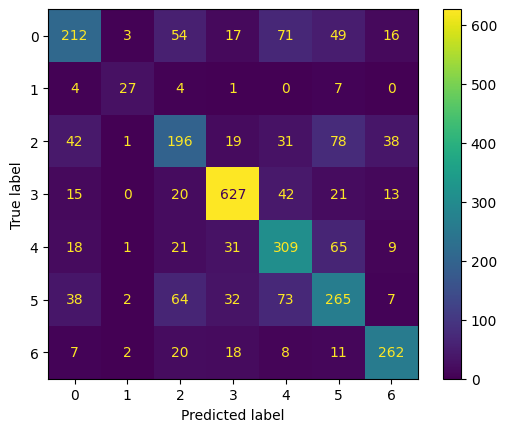

In [ ]:
X_val = tf.stack(X_val)

pred = tf.nn.softmax(best_model.predict(X_val))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_val, axis=1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [ ]:
y_pred_proba = tf.nn.softmax(best_model.predict(X_val))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)

90/90 [==============================] - 0s 2ms/step
ROC_AUC Score: 0.9029250412448064
Cohen_Kappa Score: 0.5893038396759457
F1 Score: 0.6478686639560897
Matthews Correlation Coefficient: 0.5899593771118247
Log Loss: 1.653203007500072
Accuracy: 0.6610936955764541


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Text(0, 0.5, 'Loss')

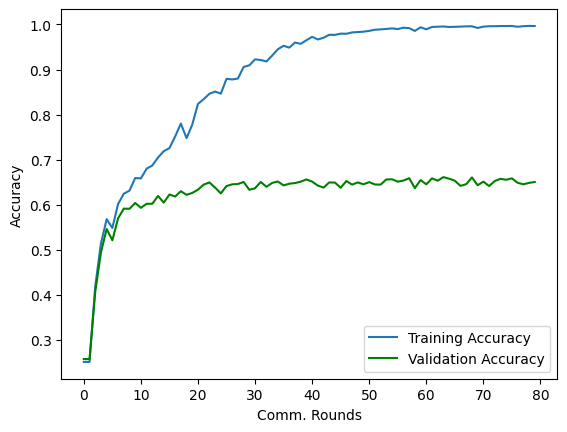

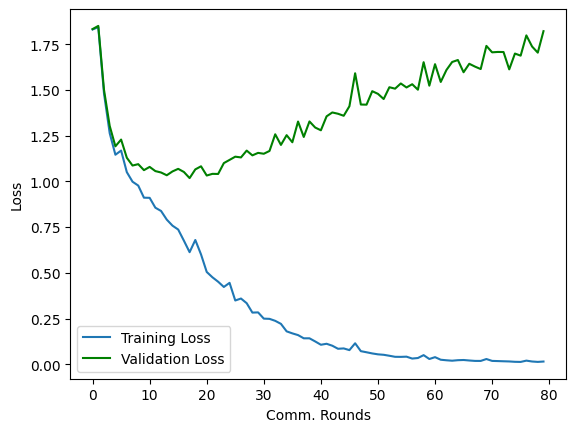

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = Tr_Accu
val_acc  = Accu
loss     = Tr_Loss
val_loss = Loss

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Loss')

# **Test Set Evaluation**

225/225 [==============================] - 1s 2ms/step


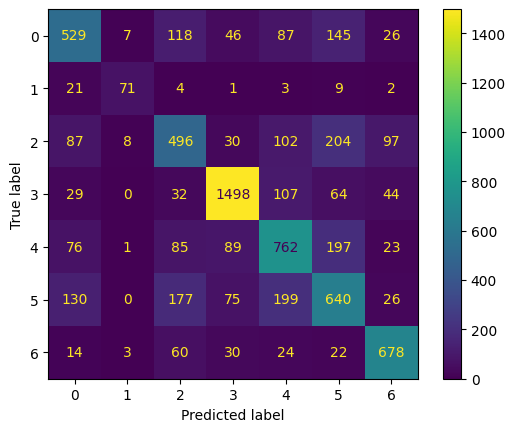

225/225 [==============================] - 1s 2ms/step
ROC_AUC Score: 0.9026232205635036
Cohen_Kappa Score: 0.5781434432444448
F1 Score: 0.6456876947874006
Matthews Correlation Coefficient: 0.5782544844758316
Log Loss: 1.6722964762562242
Accuracy: 0.6511563109501254


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
pred = tf.nn.softmax(best_model.predict(X_test))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_test, axis = 1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

y_pred_proba = tf.nn.softmax(best_model.predict(X_test))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)